# TSUNAMI: Getting Started Vignette

This notebook provides a comprehensive walkthrough of the TSUNAMI library, demonstrating its core functionalities including:
- Data loading and preprocessing
- Single-risk survival analysis
- Multi-task learning (survival, classification, regression)
- Feature importance and interpretation
- Using sample weights

In [39]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import warnings

# Add the project root to the Python path
# Adjust this path if running the notebook from a different location
project_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import TSUNAMI modules
from source.data.processing import DataProcessor
from source.models import EnhancedDeepHit
from source.models.tasks.base import TaskHead
from source.models.tasks.standard import ClassificationHead, RegressionHead
from source.models.tasks.survival import SingleRiskHead
from source.visualization.importance.importance import (
    PermutationImportance,
    ShapImportance,
    IntegratedGradients,
    AttentionImportance
)
from source.visualization.survival_plots import (
    plot_survival_curve,
    plot_cumulative_incidence,
    plot_calibration_curve
)
from source.visualization.feature_effects import (
    plot_partial_dependence,
    plot_ice_curves,
    plot_feature_interaction
)

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create output directory for plots relative to the notebook location
os.makedirs("plots", exist_ok=True)
print("Setup complete. Output directory 'plots' created.")

Setup complete. Output directory 'plots' created.


## 1. Load and Explore Data

We'll use the European Bone Marrow Transplant (`ebmt3.csv`) dataset included in the `vignettes` directory.

In [40]:
# Load the EBMT dataset
print("Loading EBMT dataset...")
try:
    ebmt_data = pd.read_csv('ebmt3.csv')
    print(f"Dataset loaded: {ebmt_data.shape[0]} patients, {ebmt_data.shape[1]} variables")
except FileNotFoundError:
    print("Error: ebmt3.csv not found. Make sure it's in the same directory as the notebook.")
    # Handle error appropriately, e.g., exit or raise
    raise

# Display dataset information
print("\nDataset Information:")
print(ebmt_data.head())
print("\nVariable types and counts:")
print(ebmt_data.dtypes)
print("\nMissing values:")
print(ebmt_data.isnull().sum())

Loading EBMT dataset...
Dataset loaded: 8966 patients, 10 variables

Dataset Information:
   Unnamed: 0  id       time  status      cod dissub               match  \
0           1   1  24.453574       0    Alive    CML     Gender mismatch   
1           2   2  14.626130       1  Relapse    CML  No gender mismatch   
2           3   3   4.437141       6    Other    CML  No gender mismatch   
3           4   4  32.703369       0    Alive    AML  No gender mismatch   
4           5   5  19.030403       1  Relapse    AML  No gender mismatch   

      tcd       year    age  
0  No TCD  1995-1998    >40  
1  No TCD  1995-1998    >40  
2  No TCD  1995-1998    >40  
3  No TCD  1995-1998  20-40  
4  No TCD  1995-1998  20-40  

Variable types and counts:
Unnamed: 0      int64
id              int64
time          float64
status          int64
cod            object
dissub         object
match          object
tcd            object
year           object
age            object
dtype: object

Missing va

In [41]:
# Basic statistics of the time-to-event variables
print("\nTime-to-event statistics:")
print("\ntime:")
print(ebmt_data['time'].describe())

# Event counts
print("\nEvent counts:")
print("\nstatus:")
print(ebmt_data['status'].value_counts())

# Categorical variable distributions
print("\nCategorical variable distributions:")
for cat_var in ['dissub', 'age', 'match', 'tcd']:
    print(f"\n{cat_var}:")
    print(ebmt_data[cat_var].value_counts())


Time-to-event statistics:

time:
count    8966.000000
mean       52.223723
std        48.957706
min         0.001000
25%         7.428102
50%        40.838127
75%        84.831553
max       211.372227
Name: time, dtype: float64

Event counts:

status:
0    5656
1    1098
6     924
2     834
5     156
3     151
4     147
Name: status, dtype: int64

Categorical variable distributions:

dissub:
CML    3582
AML    3514
ALL    1870
Name: dissub, dtype: int64

age:
20-40    4800
>40      2192
<=20     1974
Name: age, dtype: int64

match:
No gender mismatch    6758
Gender mismatch       2208
Name: match, dtype: int64

tcd:
No TCD     4390
Unknown    2856
TCD        1720
Name: tcd, dtype: int64


## 2. Create Synthetic Variables for Multi-Task Demonstration

To showcase TSUNAMI's multi-task capabilities, we'll create synthetic target variables for binary classification, regression, and competing risks based on the original data.

In [42]:
print("\nCreating synthetic variables for demonstration...")

# Rename columns for clarity in modeling
ebmt_data = ebmt_data.rename(columns={
    'time': 'survival_time',
    'status': 'event_indicator',
    'match': 'drmatch'  # More descriptive name
})

# Simplify event indicator for demonstration (0: censored, 1: event)
# Original dataset has 0, 1, 2, 3, 4, 5, 6 statuses
ebmt_data['event_indicator'] = (ebmt_data['event_indicator'] > 0).astype(int)

# Synthetic binary classification target
ebmt_data['binary_outcome'] = np.random.binomial(1, 0.3, size=len(ebmt_data))

# Synthetic regression target (e.g., biomarker value) - not using survival_time to avoid data leakage
age_effect = 0.3 * (ebmt_data['age'] == ">40").astype(int) * 10
dissub_effect = 0.2 * (ebmt_data['dissub'] == "ALL").astype(int) * 5
ebmt_data['biomarker'] = age_effect + dissub_effect + np.random.normal(15, 5, size=len(ebmt_data))

# Synthetic competing risks (create a cause indicator from 'cod' column)
# 0: censored, 1: Relapse, 2: Death without relapse
ebmt_data['cr_cause'] = 0  # Default to censored
ebmt_data.loc[ebmt_data['event_indicator'] == 1, 'cr_cause'] = 1  # Relapse as default event
# Randomly assign half of the events to cause 2 (death) for demonstration
event_mask = ebmt_data['event_indicator'] == 1
event_indices = ebmt_data[event_mask].index
cause2_indices = np.random.choice(event_indices, size=len(event_indices) // 2, replace=False)
ebmt_data.loc[cause2_indices, 'cr_cause'] = 2

print("Synthetic variables created:")
print(" - 'binary_outcome': Binary classification target")
print(" - 'biomarker': Regression target")
print(" - 'cr_cause': Competing risks cause (0: censored, 1: relapse, 2: death)")
print("\nUpdated DataFrame head:")
print(ebmt_data[['survival_time', 'event_indicator', 'binary_outcome', 'biomarker', 'cr_cause']].head())


Creating synthetic variables for demonstration...
Synthetic variables created:
 - 'binary_outcome': Binary classification target
 - 'biomarker': Regression target
 - 'cr_cause': Competing risks cause (0: censored, 1: relapse, 2: death)

Updated DataFrame head:
   survival_time  event_indicator  binary_outcome  biomarker  cr_cause
0      24.453574                0               0  25.680306         0
1      14.626130                1               1  20.987689         1
2       4.437141                1               1  14.443484         1
3      32.703369                0               0  15.585621         0
4      19.030403                1               0  16.181118         1


## 3. Data Preprocessing

We use the `DataProcessor` utility for handling missing values, encoding categorical features, and normalizing numeric features.

In [43]:
print("\nPreprocessing data...")

# Define feature columns 
numeric_features = []  # Not using survival_time as feature to avoid data leakage
categorical_features = ['dissub', 'age', 'drmatch', 'tcd']

# Create a preprocessor
preprocessor = DataProcessor(
    num_impute_strategy='median',
    cat_impute_strategy='most_frequent',
    normalize='robust'
)

# Prepare feature dataframe - only using actual features, not target variables
feature_df = ebmt_data[categorical_features].copy()  # No numeric features used

# Fit the preprocessor and transform the data
preprocessor.fit(feature_df)
processed_df = preprocessor.transform(feature_df)

print("\nPreprocessed data:")
print(processed_df.head())


Preprocessing data...

Preprocessed data:
   dissub_embed_0  dissub_embed_1  age_embed_0  age_embed_1  drmatch_embed_0  \
0            0.00             0.0         0.00          0.0         0.000000   
1            0.00             0.0         0.00          0.0         0.333333   
2            0.00             0.0         0.00          0.0         0.333333   
3            0.25             0.0         0.25          0.0         0.333333   
4            0.25             0.0         0.25          0.0         0.333333   

   tcd_embed_0  tcd_embed_1  
0          0.0          0.0  
1          0.0          0.0  
2          0.0          0.0  
3          0.0          0.0  
4          0.0          0.0  


In [44]:
# Convert features to PyTorch tensor
X_tensor = torch.tensor(processed_df.values, dtype=torch.float32)
print(f"\nFeature tensor shape: {X_tensor.shape}")


Feature tensor shape: torch.Size([8966, 7])


## 4. Prepare Target Variables

Target variables need to be formatted correctly for each task head (Survival, Competing Risks, Classification, Regression).

In [45]:
# Prepare time and event data for SingleRiskHead
# Discretize time into bins
num_time_bins = 20
max_time = np.percentile(ebmt_data['survival_time'], 99)
bin_edges = np.linspace(0, max_time, num_time_bins + 1)
time_bins = np.digitize(ebmt_data['survival_time'], bin_edges) - 1
time_bins = np.clip(time_bins, 0, num_time_bins - 1)

# Create target format for SingleRiskHead
# [event_indicator, time_bin, one_hot_encoding]
single_risk_target = np.zeros((len(ebmt_data), 2 + num_time_bins))
single_risk_target[:, 0] = ebmt_data['event_indicator'].values
single_risk_target[:, 1] = time_bins

# One-hot encoding of time
for i in range(len(ebmt_data)):
    if ebmt_data['event_indicator'].iloc[i]:
        # For events, mark the event time
        single_risk_target[i, 2 + int(time_bins[i])] = 1
    else:
        # For censored, mark all times after censoring as unknown (-1)
        single_risk_target[i, 2 + int(time_bins[i]):] = -1

print(f"Single risk target shape: {single_risk_target.shape}")

Single risk target shape: (8966, 22)


In [46]:
# Create target for CompetingRisksHead
# [event_indicator, time_bin, cause_index, one_hot_encoding]
# Note: CompetingRisksHead is not fully implemented yet, this is for future use.
competing_risks_target = np.zeros((len(ebmt_data), 3 + num_time_bins * 2)) # Assuming 2 competing risks
competing_risks_target[:, 0] = (ebmt_data['cr_cause'] > 0).astype(float)  # Event indicator
competing_risks_target[:, 1] = time_bins
competing_risks_target[:, 2] = ebmt_data['cr_cause'] - 1  # -1 for censored, 0 for cause 1, 1 for cause 2
competing_risks_target[competing_risks_target[:, 2] < 0, 2] = -1  # Ensure censored is -1

# One-hot encoding for competing risks (placeholder logic)
# This part would need refinement based on the final CompetingRisksHead implementation

print(f"Competing risks target shape: {competing_risks_target.shape}")

Competing risks target shape: (8966, 43)


In [47]:
# Convert targets to tensors
single_risk_tensor = torch.tensor(single_risk_target, dtype=torch.float32)
competing_risks_tensor = torch.tensor(competing_risks_target, dtype=torch.float32)
binary_tensor = torch.tensor(ebmt_data['binary_outcome'].values, dtype=torch.float32).unsqueeze(1)
regression_tensor = torch.tensor(ebmt_data['biomarker'].values, dtype=torch.float32).unsqueeze(1)

print(f"Single risk tensor shape: {single_risk_tensor.shape}")
print(f"Competing risks tensor shape: {competing_risks_tensor.shape}")
print(f"Binary tensor shape: {binary_tensor.shape}")
print(f"Regression tensor shape: {regression_tensor.shape}")

Single risk tensor shape: torch.Size([8966, 22])
Competing risks tensor shape: torch.Size([8966, 43])
Binary tensor shape: torch.Size([8966, 1])
Regression tensor shape: torch.Size([8966, 1])


## 5. Create Dataset and Dataloaders

We define a custom PyTorch `Dataset` to handle the features and multiple target types.

In [48]:
# Create dataset and dataloader with proper formatting
class SurvivalDataset(torch.utils.data.Dataset):
    def __init__(self, X, sr_targets=None, cr_targets=None, binary_targets=None, regression_targets=None):
        self.X = X
        self.sr_targets = sr_targets
        self.cr_targets = cr_targets
        self.binary_targets = binary_targets
        self.regression_targets = regression_targets
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        item = {'continuous': self.X[idx]}
        targets = {}
        
        if self.sr_targets is not None:
            targets['survival'] = self.sr_targets[idx]
        
        if self.cr_targets is not None:
            targets['competing_risks'] = self.cr_targets[idx]
            
        if self.binary_targets is not None:
            targets['binary'] = self.binary_targets[idx]
            
        if self.regression_targets is not None:
            targets['regression'] = self.regression_targets[idx]
            
        item['targets'] = targets
        return item

print("SurvivalDataset class defined.")

SurvivalDataset class defined.


In [49]:
# Create full multi-task dataset (including all targets)
full_dataset = SurvivalDataset(
    X_tensor, 
    sr_targets=single_risk_tensor,
    cr_targets=competing_risks_tensor,
    binary_targets=binary_tensor,
    regression_targets=regression_tensor
)
print(f"Full dataset created with {len(full_dataset)} samples.")

Full dataset created with 8966 samples.


In [50]:
# Split data into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Create random split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"Datasets prepared: {len(train_dataset)} train, {len(val_dataset)} validation, {len(test_dataset)} test samples")

Datasets prepared: 6276 train, 1344 validation, 1346 test samples


In [51]:
# Create dataloaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

print(f"Dataloaders created with batch size {batch_size}.")

Dataloaders created with batch size 64.


## 6. Demonstration 1: Single Risk Survival Analysis

Train and evaluate a model focused solely on single-risk survival.

In [52]:
print("\n--- DEMONSTRATION 1: SINGLE RISK SURVIVAL ANALYSIS ---\n")

# Create single risk task head
sr_task_head = SingleRiskHead(
    name='survival',
    input_dim=64, # Should match encoder_dim
    num_time_bins=num_time_bins,
    alpha_rank=0.1,
    alpha_calibration=0.0  # Disable calibration loss due to potential issues
)

# Create the EnhancedDeepHit model for single risk
sr_model = EnhancedDeepHit(
    num_continuous=X_tensor.shape[1],
    targets=[sr_task_head],
    encoder_dim=64,
    encoder_depth=2,
    encoder_heads=4,
    include_variational=True, # Enable uncertainty estimation
    device='cpu' # Use 'cuda' if GPU is available
)

print("Single risk model created.")


--- DEMONSTRATION 1: SINGLE RISK SURVIVAL ANALYSIS ---

Single risk model created.


In [53]:
# Train the single risk model
print("Training single risk model...")
sr_history = sr_model.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5,  # Reduced for speed in vignette
    learning_rate=0.001,
    patience=3
)
print("Single risk model training complete.")

Training single risk model...
Epoch 1/5, Train Loss: 0.4705, Val Loss: 0.2953
  survival_c_index: 0.5013
  survival_brier_score: 0.2438
  survival_auc: 0.5123
Epoch 2/5, Train Loss: 0.3251, Val Loss: 0.2933
  survival_c_index: 0.5044
  survival_brier_score: 0.2727
  survival_auc: 0.5168
Epoch 3/5, Train Loss: 0.3148, Val Loss: 0.2932
  survival_c_index: 0.5196
  survival_brier_score: 0.2804
  survival_auc: 0.5231
Epoch 4/5, Train Loss: 0.3102, Val Loss: 0.2934
  survival_c_index: 0.5187
  survival_brier_score: 0.2796
  survival_auc: 0.5204
Epoch 5/5, Train Loss: 0.3053, Val Loss: 0.2860
  survival_c_index: 0.5649
  survival_brier_score: 0.2702
  survival_auc: 0.5686
Restored model from epoch 5
Single risk model training complete.


In [54]:
# Generate predictions for the test set
print("\nGenerating predictions for test set...")
# Extract features from the test dataset
X_test = torch.cat([test_dataset[i]['continuous'].unsqueeze(0) for i in range(len(test_dataset))])

single_risk_preds = sr_model.predict(X_test)

# Extract survival curves and uncertainty
sr_survival_curves = single_risk_preds['task_outputs']['survival']['survival'].detach().numpy()

# Compute uncertainty for a subset (faster)
sr_uncertainty = sr_model.compute_uncertainty(X_test[:10], num_samples=10) # Reduced samples for speed
sr_survival_std = sr_uncertainty['survival']['std'].detach().numpy()

# Verify survival curves start near 1.0
print("\nVerifying survival curves start near 1.0:")
print(f"First survival curve start values: {sr_survival_curves[0, :5]}")
print(f"Survival curves shape: {sr_survival_curves.shape}")
print(f"Uncertainty (std) shape: {sr_survival_std.shape}")


Generating predictions for test set...

Verifying survival curves start near 1.0:
First survival curve start values: [1.        0.6863047 0.625488  0.599706  0.5852431]
Survival curves shape: (1346, 20)
Uncertainty (std) shape: (10, 20)


### Plotting Single Risk Results


Plotting survival curves...


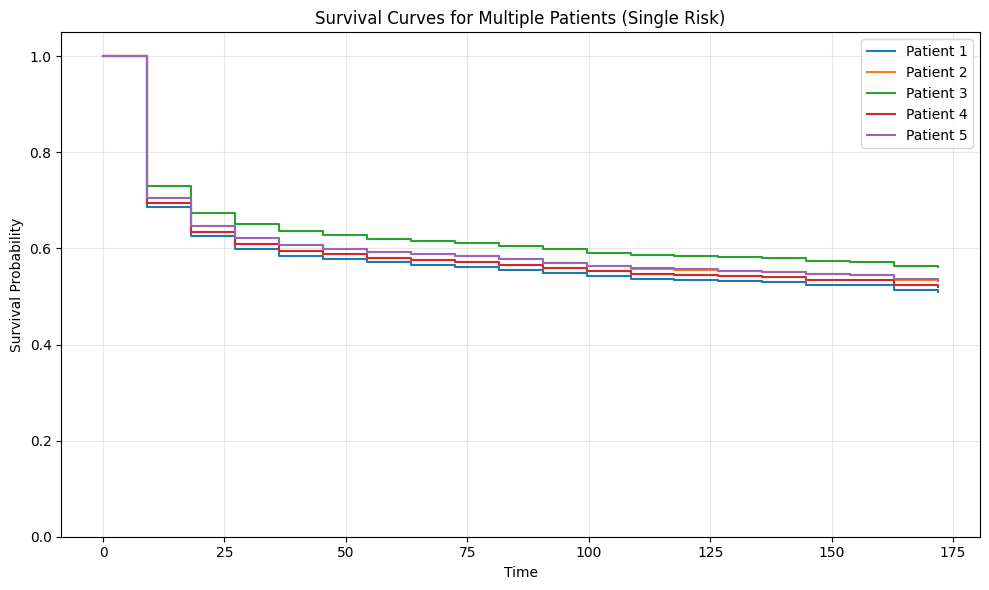

In [55]:
# Plot single risk survival curves
print("\nPlotting survival curves...")
time_points = bin_edges[:-1]  # Use bin start points as time points

# Plot survival curves for first 5 patients
fig1 = plot_survival_curve(
    sr_survival_curves[:5],
    time_points=time_points,
    labels=[f'Patient {i+1}' for i in range(5)],
    title="Survival Curves for Multiple Patients (Single Risk)"
)
fig1.savefig("plots/sr_survival_curves.png")
plt.show() # Display plot in notebook
plt.close(fig1)

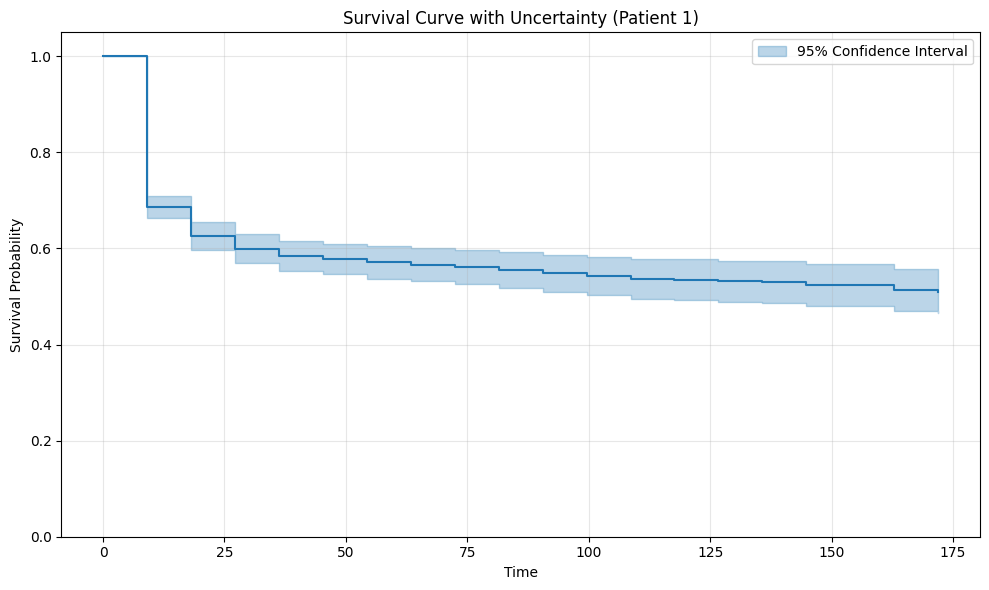

In [56]:
# Plot survival curve with uncertainty for the first patient
fig2 = plot_survival_curve(
    sr_survival_curves[0],
    time_points=time_points,
    uncertainty=sr_survival_std[0],
    title="Survival Curve with Uncertainty (Patient 1)"
)
fig2.savefig("plots/sr_survival_uncertainty.png")
plt.show()
plt.close(fig2)

### Feature Importance (Single Risk)


Calculating Permutation Importance...


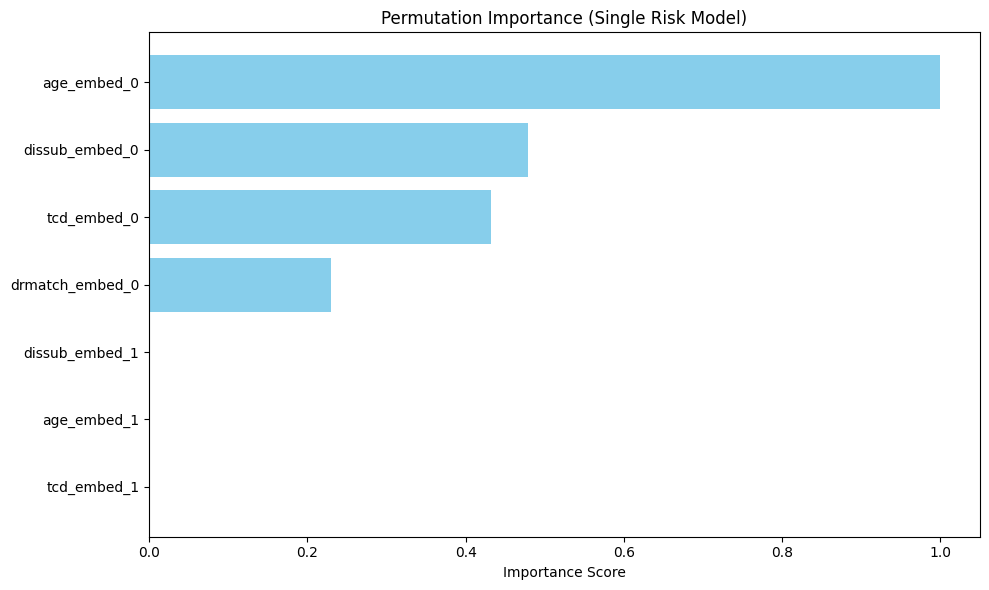

In [57]:
# Calculate Permutation Importance
print("\nCalculating Permutation Importance...")
perm_imp = PermutationImportance(sr_model)

# Extract targets for the test subset used for importance
test_subset_size = 100 # Use a subset for faster computation
survival_targets_subset = torch.cat([test_dataset[i]['targets']['survival'].unsqueeze(0) for i in range(test_subset_size)])

perm_importances = perm_imp.compute_importance(
    {'continuous': X_test[:test_subset_size]},
    y=survival_targets_subset,
    n_repeats=3, # Reduced repeats for speed
    feature_names=processed_df.columns.tolist()
)

# Plot permutation importance
fig3 = perm_imp.plot_importance(perm_importances)
plt.title("Permutation Importance (Single Risk Model)")
fig3.savefig("plots/sr_permutation_importance.png")
plt.show()
plt.close(fig3)

### Feature Effects (Single Risk)

Visualize how individual features influence the model's predictions using Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) curves.


Generating partial dependence plots...


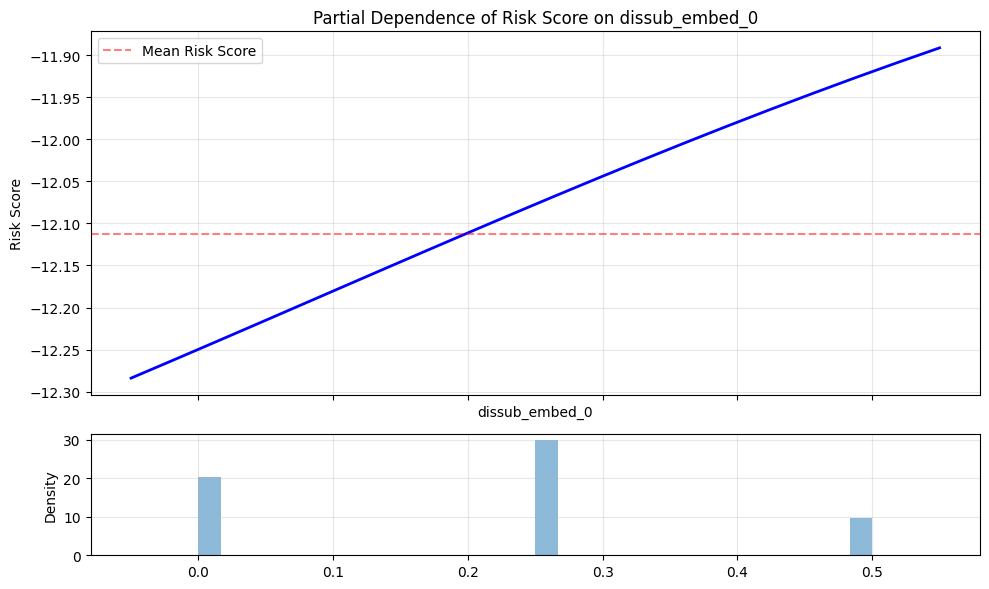

In [58]:
# Partial dependence plots for categorical features
print("\nGenerating partial dependence plots...")

# Find index for a categorical feature embedding (e.g., first embedding dim of 'dissub')
try:
    categorical_idx = processed_df.columns.get_loc('dissub_embed_0')
    categorical_feature_name = processed_df.columns[categorical_idx]

    fig4 = plot_partial_dependence(
        sr_model,
        X_test[:test_subset_size], # Use subset
        feature_idx=categorical_idx,
        feature_name=categorical_feature_name,
        target='risk_score', # Predict risk score
        title=f"Partial Dependence of Risk Score on {categorical_feature_name}"
    )
    fig4.savefig("plots/sr_pd_categorical1.png")
    plt.show()
    plt.close(fig4)
except KeyError:
    print(f"Warning: Feature 'dissub_embed_0' not found in preprocessed columns. Skipping PDP plot.")

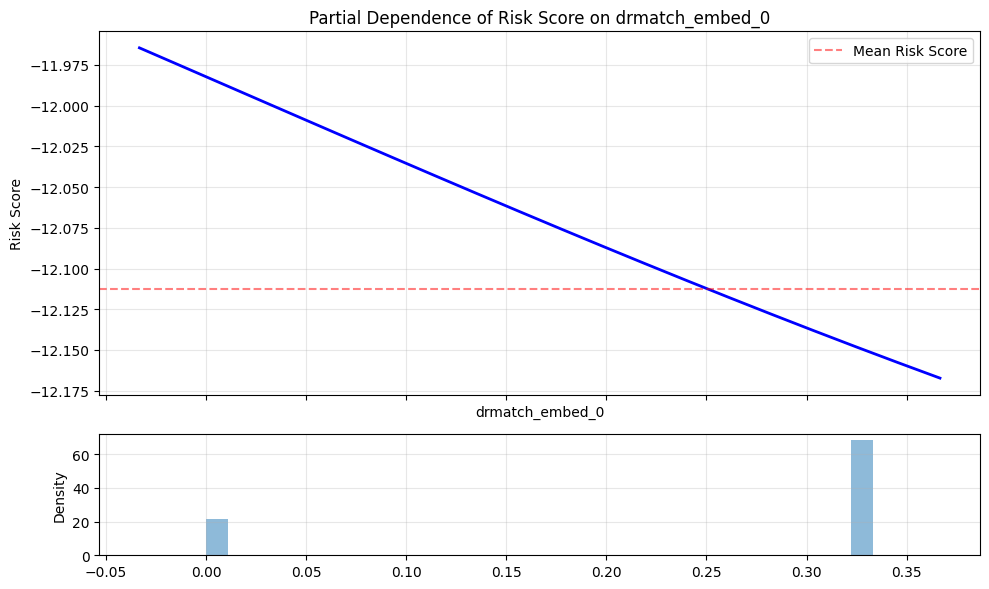

In [59]:
# Partial dependence for another categorical feature (e.g., 'drmatch')
try:
    categorical_idx_other = processed_df.columns.get_loc('drmatch_embed_0')
    categorical_feature_name_other = processed_df.columns[categorical_idx_other]

    fig5 = plot_partial_dependence(
        sr_model,
        X_test[:test_subset_size],
        feature_idx=categorical_idx_other,
        feature_name=categorical_feature_name_other,
        target='risk_score',
        title=f"Partial Dependence of Risk Score on {categorical_feature_name_other}"
    )
    fig5.savefig("plots/sr_pd_categorical.png")
    plt.show()
    plt.close(fig5)
except KeyError:
     print(f"Warning: Feature 'drmatch_embed_0' not found in preprocessed columns. Skipping PDP plot.")

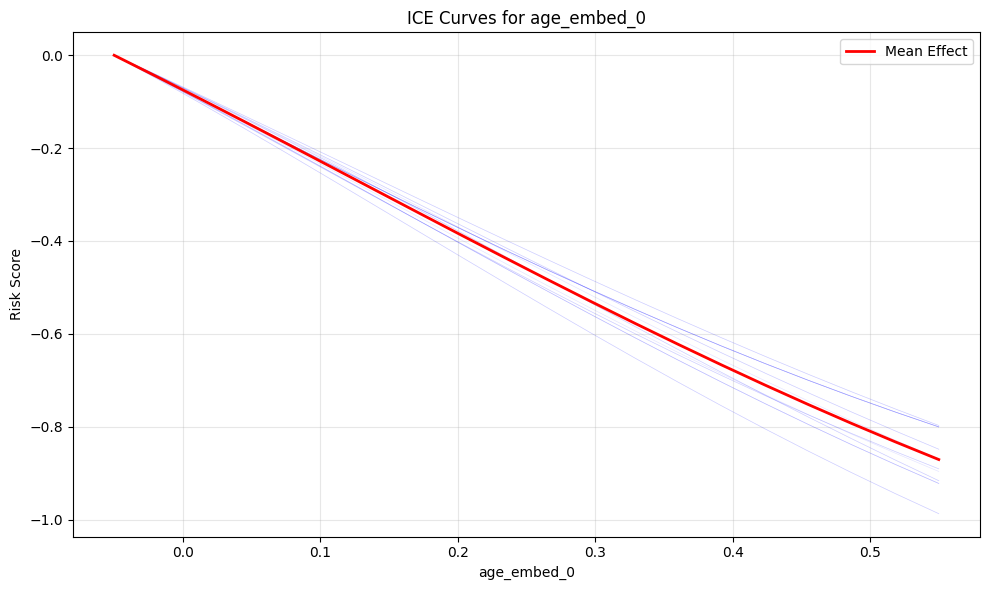

In [60]:
# ICE curves for a categorical feature (e.g., 'age')
try:
    categorical_idx2 = processed_df.columns.get_loc('age_embed_0')
    categorical_feature_name2 = processed_df.columns[categorical_idx2]

    fig6 = plot_ice_curves(
        sr_model,
        X_test[:20], # Use fewer samples for ICE clarity
        feature_idx=categorical_idx2,
        feature_name=categorical_feature_name2,
        target='risk_score',
        title=f"ICE Curves for {categorical_feature_name2}"
    )
    fig6.savefig("plots/sr_ice_curves.png")
    plt.show()
    plt.close(fig6)
except KeyError:
     print(f"Warning: Feature 'age_embed_0' not found in preprocessed columns. Skipping ICE plot.")

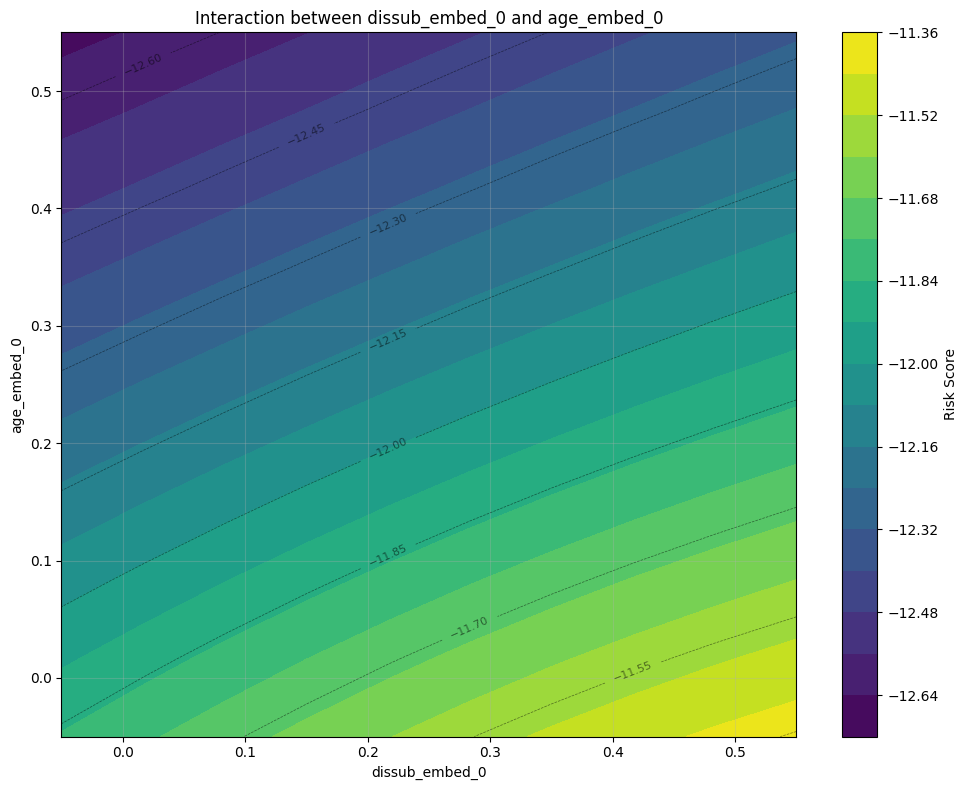

In [61]:
# Feature interaction between two categorical features
try:
    # Ensure both features exist before plotting interaction
    categorical_idx = processed_df.columns.get_loc('dissub_embed_0')
    categorical_idx2 = processed_df.columns.get_loc('age_embed_0')
    categorical_feature_name = processed_df.columns[categorical_idx]
    categorical_feature_name2 = processed_df.columns[categorical_idx2]

    fig7 = plot_feature_interaction(
        sr_model,
        X_test[:test_subset_size],
        feature1_idx=categorical_idx,
        feature2_idx=categorical_idx2,
        feature1_name=categorical_feature_name,
        feature2_name=categorical_feature_name2,
        target='risk_score',
        title=f"Interaction between {categorical_feature_name} and {categorical_feature_name2}"
    )
    fig7.savefig("plots/sr_feature_interaction.png")
    plt.show()
    plt.close(fig7)
except KeyError as e:
    print(f"Warning: Feature {e} not found. Skipping feature interaction plot.")

## 7. Demonstration 2: Competing Risks Analysis (Placeholder)

**Note:** The `CompetingRisksHead` is currently under development. This section uses dummy data to illustrate the expected plotting functionalities.

In [62]:
print("\n--- DEMONSTRATION 2: COMPETING RISKS ANALYSIS (Placeholder) ---\n")
print("Skipping competing risks model training as CompetingRisksHead is not yet implemented.")
print("Using dummy data for plotting examples.")

# Create dummy data for plotting examples
time_scale = np.linspace(0, 1, num_time_bins)
dummy_cif = np.zeros((2, num_time_bins)) # 2 competing risks
dummy_cif[0, :] = 0.3 * (1 - np.exp(-time_scale * 2))  # Risk 1 (e.g., Relapse)
dummy_cif[1, :] = 0.4 * (1 - np.exp(-time_scale * 1.5))  # Risk 2 (e.g., Death)

# Ensure CIF is monotonically increasing and valid
dummy_cif = np.cumsum(np.clip(np.diff(dummy_cif, axis=1, prepend=0), 0, 1), axis=1)
dummy_cif = np.clip(dummy_cif, 0, 1)

# Overall survival = 1 - sum(CIF)
dummy_survival = 1 - np.sum(dummy_cif, axis=0)

# Repeat for 5 patients with slight variations for multi-patient plot
dummy_survival_multi = np.array([np.clip(dummy_survival * (0.9 + 0.2 * np.random.rand()), 0, 1) for _ in range(5)])

# Use these as our "predictions"
cr_cif = dummy_cif
cr_survival = dummy_survival_multi


--- DEMONSTRATION 2: COMPETING RISKS ANALYSIS (Placeholder) ---

Skipping competing risks model training as CompetingRisksHead is not yet implemented.
Using dummy data for plotting examples.


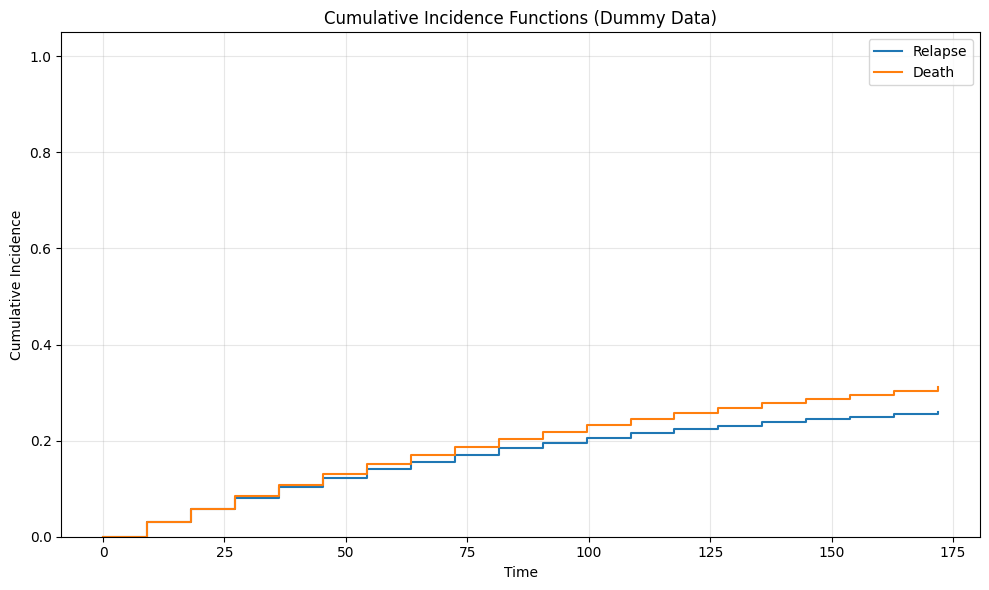

In [63]:
# Plot competing risks Cumulative Incidence Functions (CIF)
fig8 = plot_cumulative_incidence(
    cr_cif,  # Shape: [num_risks, num_time_bins]
    time_points=time_points,
    risk_names=['Relapse', 'Death'],
    title="Cumulative Incidence Functions (Dummy Data)"
)
fig8.savefig("plots/cr_cif.png")
plt.show()
plt.close(fig8)

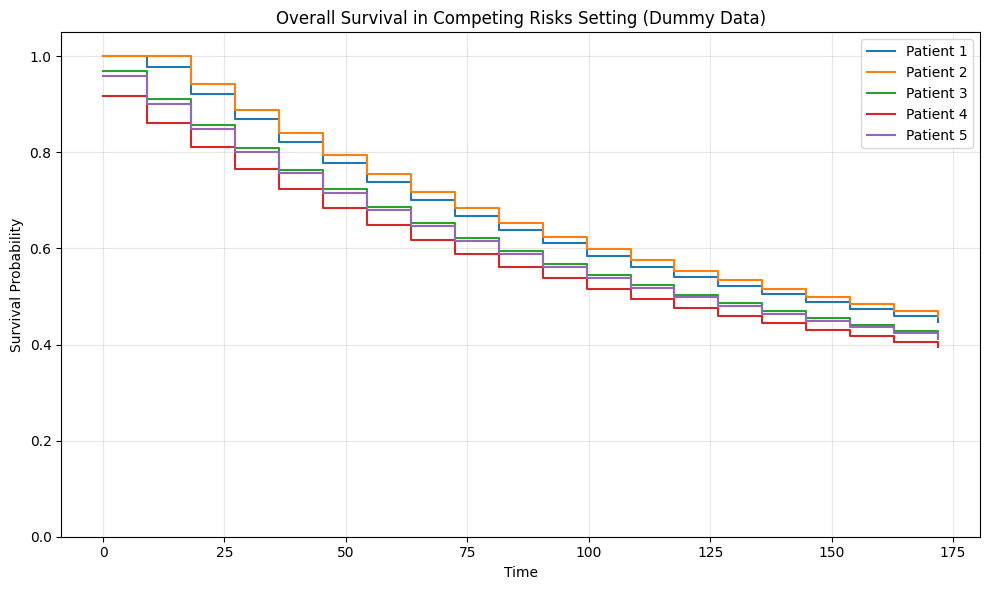

In [64]:
# Plot competing risks overall survival
fig9 = plot_survival_curve(
    cr_survival[:5], # Shape: [num_patients, num_time_bins]
    time_points=time_points,
    labels=[f'Patient {i+1}' for i in range(5)],
    title="Overall Survival in Competing Risks Setting (Dummy Data)"
)
fig9.savefig("plots/cr_overall_survival.png")
plt.show()
plt.close(fig9)

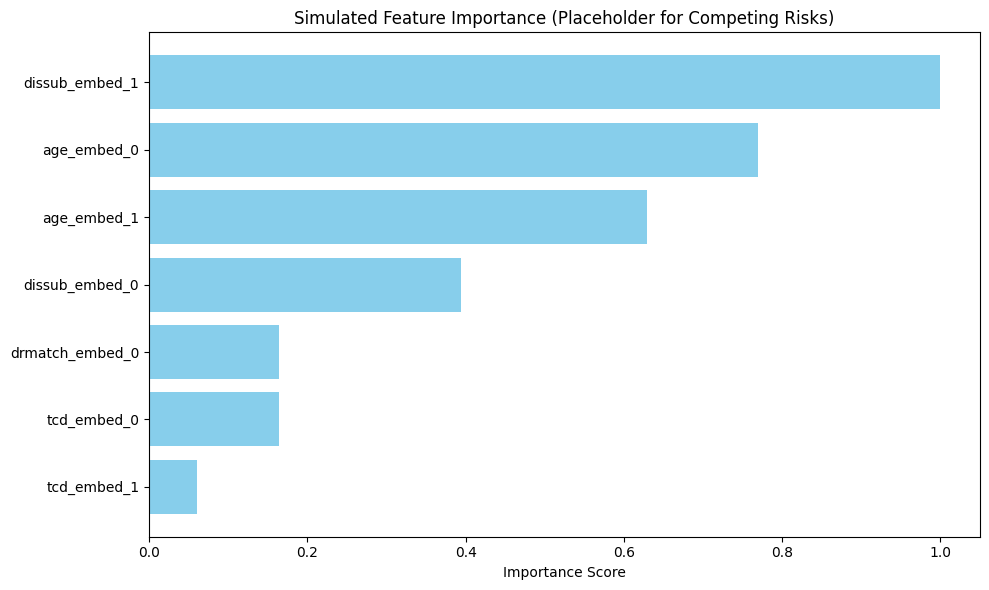

In [65]:
# Plot dummy feature importance for competing risks
np.random.seed(42)  # For reproducibility
cr_perm_importances = {}
for col in processed_df.columns:
    cr_perm_importances[col] = np.random.rand()

# Normalize values
max_val = max(cr_perm_importances.values()) if cr_perm_importances else 1
for key in cr_perm_importances:
    cr_perm_importances[key] /= max_val

# Plot importance using generic plotting method
fig10, ax10 = plt.subplots(figsize=(10, 6))
sorted_importance = sorted(cr_perm_importances.items(), key=lambda x: x[1], reverse=True)
feature_names = [x[0] for x in sorted_importance]
scores = [x[1] for x in sorted_importance]
y_pos = np.arange(len(feature_names))
ax10.barh(y_pos, scores, color='skyblue')
ax10.set_yticks(y_pos)
ax10.set_yticklabels(feature_names)
ax10.invert_yaxis()  # Labels read top-to-bottom
ax10.set_xlabel('Importance Score')
ax10.set_title("Simulated Feature Importance (Placeholder for Competing Risks)")
plt.tight_layout()
fig10.savefig("plots/cr_permutation_importance.png")
plt.show()
plt.close(fig10)

## 8. Demonstration 3: Multi-Task Learning

Train a single model to simultaneously predict survival, binary outcome, and a regression target.

In [66]:
print("\n--- DEMONSTRATION 3: MULTI-TASK LEARNING ---\n")

# Create task heads for multi-task model
mt_survival_head = SingleRiskHead(
    name='survival',
    input_dim=64,
    num_time_bins=num_time_bins,
    alpha_rank=0.1,
    alpha_calibration=0.0  # Disable calibration loss
)

mt_binary_head = ClassificationHead(
    name='binary',
    input_dim=64,
    num_classes=2, # Binary classification
    task_weight=1.0 # Adjust weight relative to other tasks if needed
)

mt_regression_head = RegressionHead(
    name='regression',
    input_dim=64,
    output_dim=1, # Single regression target
    task_weight=1.0
)

print("Multi-task heads defined.")


--- DEMONSTRATION 3: MULTI-TASK LEARNING ---

Multi-task heads defined.


In [67]:
# Create the multi-task EnhancedDeepHit model
mt_model = EnhancedDeepHit(
    num_continuous=X_tensor.shape[1],
    targets=[mt_survival_head, mt_binary_head, mt_regression_head],
    encoder_dim=64,
    encoder_depth=2,
    encoder_heads=4,
    include_variational=True, # Can estimate uncertainty for all tasks
    device='cpu'
)

print("Multi-task model created.")

Multi-task model created.


In [68]:
# Create multi-task dataset (excluding competing risks for now)
mt_dataset = SurvivalDataset(
    X_tensor, 
    sr_targets=single_risk_tensor,
    binary_targets=binary_tensor,
    regression_targets=regression_tensor
)

# Split data
mt_train_size = int(0.7 * len(mt_dataset))
mt_val_size = int(0.15 * len(mt_dataset))
mt_test_size = len(mt_dataset) - mt_train_size - mt_val_size

# Create random split
mt_train_dataset, mt_val_dataset, mt_test_dataset = torch.utils.data.random_split(
    mt_dataset, [mt_train_size, mt_val_size, mt_test_size]
)

# Create dataloaders
mt_train_loader = torch.utils.data.DataLoader(mt_train_dataset, batch_size=batch_size, shuffle=True)
mt_val_loader = torch.utils.data.DataLoader(mt_val_dataset, batch_size=batch_size)
mt_test_loader = torch.utils.data.DataLoader(mt_test_dataset, batch_size=batch_size)

print(f"Multi-task datasets and dataloaders created: {len(mt_train_dataset)} train, {len(mt_val_dataset)} val, {len(mt_test_dataset)} test")

Multi-task datasets and dataloaders created: 6276 train, 1344 val, 1346 test


In [69]:
# Train the multi-task model
print("Training multi-task model...")
mt_history = mt_model.fit(
    train_loader=mt_train_loader,
    val_loader=mt_val_loader,
    num_epochs=5,  # Reduced for speed
    learning_rate=0.001,
    patience=3
)
print("Multi-task model training complete.")

Training multi-task model...
Epoch 1/5, Train Loss: 115.8877, Val Loss: 50.0556
  survival_c_index: 0.5008
  survival_brier_score: 0.2391
  survival_auc: 0.5118
  binary_accuracy: 0.7098
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.5259
  regression_mse: 48.5844
  regression_mae: 5.6193
  regression_r2: -118.7834
Epoch 2/5, Train Loss: 35.5884, Val Loss: 27.8304
  survival_c_index: 0.5318
  survival_brier_score: 0.2648
  survival_auc: 0.5331
  binary_accuracy: 0.7098
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.5034
  regression_mse: 26.8118
  regression_mae: 4.0902
  regression_r2: -64.6127
Epoch 3/5, Train Loss: 28.4343, Val Loss: 27.4661
  survival_c_index: 0.4905
  survival_brier_score: 0.2810
  survival_auc: 0.4949
  binary_accuracy: 0.7098
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.4950
  regression_mse: 26.6100
  regression_mae: 4.0854

In [70]:
# Generate predictions for the multi-task test set
print("\nGenerating multi-task predictions...")
X_mt_test = torch.cat([mt_test_dataset[i]['continuous'].unsqueeze(0) for i in range(len(mt_test_dataset))])
mt_preds = mt_model.predict(X_mt_test)

# Extract task-specific predictions
mt_survival = mt_preds['task_outputs']['survival']['survival'].detach().numpy()
mt_binary_probs = mt_preds['task_outputs']['binary']['probabilities'].detach().numpy() # Probability of class 1
mt_regression_values = mt_preds['task_outputs']['regression']['predictions'].detach().numpy()

print(f"Multi-task survival predictions shape: {mt_survival.shape}")
print(f"Multi-task binary probabilities shape: {mt_binary_probs.shape}")
print(f"Multi-task regression predictions shape: {mt_regression_values.shape}")


Generating multi-task predictions...
Multi-task survival predictions shape: (1346, 20)
Multi-task binary probabilities shape: (1346,)
Multi-task regression predictions shape: (1346,)


### Plotting Multi-Task Results


Plotting multi-task predictions...


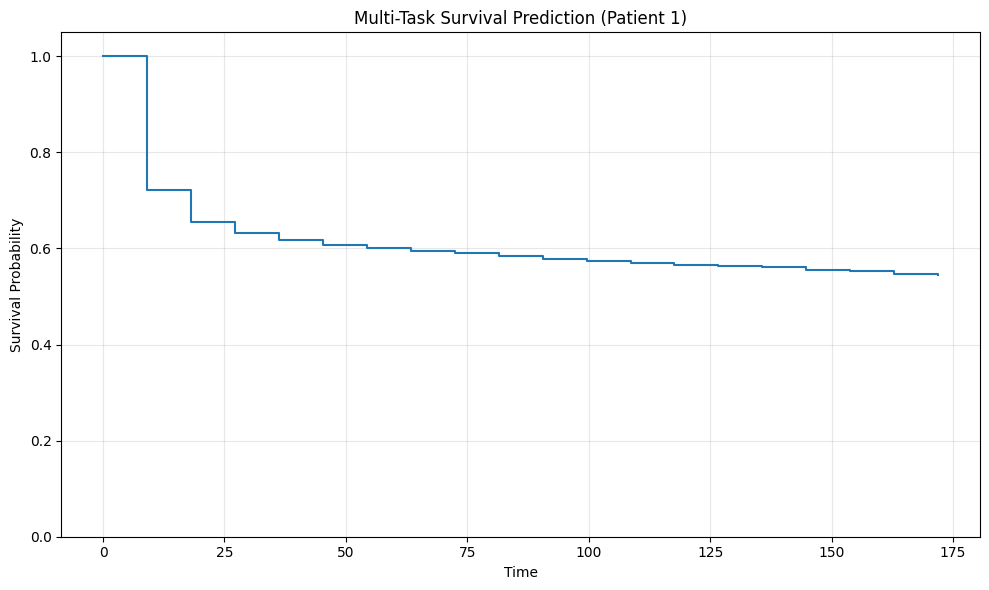

In [71]:
# Plot multi-task survival curve for the first patient
print("\nPlotting multi-task predictions...")
fig11 = plot_survival_curve(
    mt_survival[0],
    time_points=time_points,
    title="Multi-Task Survival Prediction (Patient 1)"
)
fig11.savefig("plots/mt_survival.png")
plt.show()
plt.close(fig11)

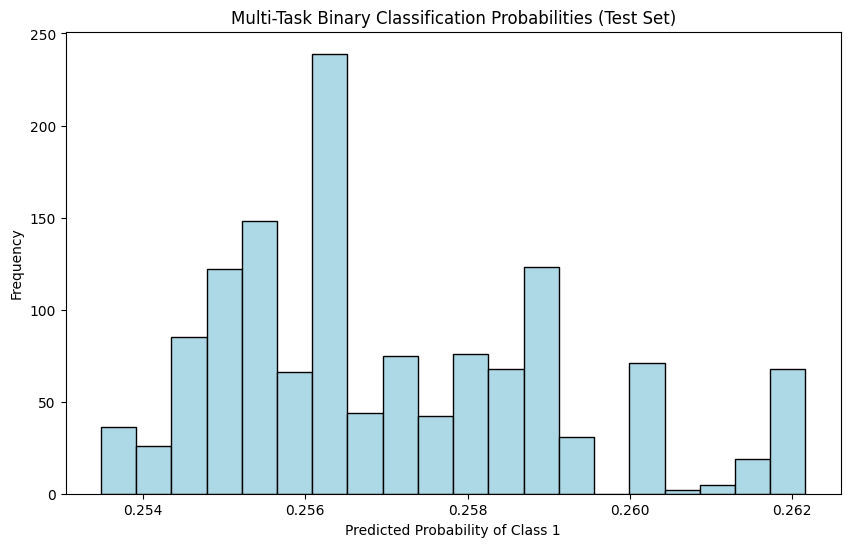

In [72]:
# Plot histogram of multi-task binary classification probabilities
fig12, ax12 = plt.subplots(figsize=(10, 6))
ax12.hist(mt_binary_probs, bins=20, color='lightblue', edgecolor='black')
ax12.set_title("Multi-Task Binary Classification Probabilities (Test Set)")
ax12.set_xlabel("Predicted Probability of Class 1")
ax12.set_ylabel("Frequency")
fig12.savefig("plots/mt_binary.png")
plt.show()
plt.close(fig12)

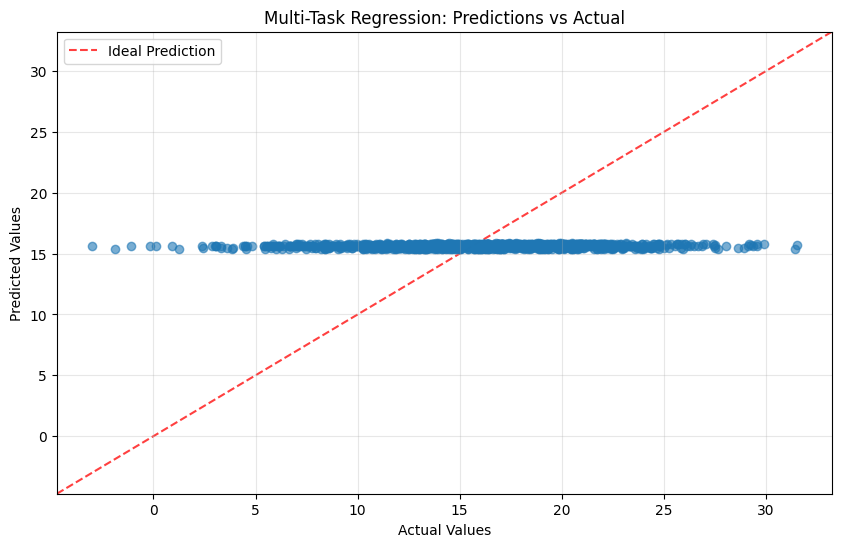

In [73]:
# Plot multi-task regression predictions vs actual values

# Extract actual regression targets from the test set
regression_targets = torch.cat([mt_test_dataset[i]['targets']['regression'] for i in range(len(mt_test_dataset))])

fig13, ax13 = plt.subplots(figsize=(10, 6))
ax13.scatter(regression_targets.numpy(), mt_regression_values.flatten(), alpha=0.6)
# Add identity line
lims = [
    np.min([ax13.get_xlim(), ax13.get_ylim()]),  # min of both axes
    np.max([ax13.get_xlim(), ax13.get_ylim()]),  # max of both axes
]
ax13.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Ideal Prediction')
ax13.set_xlim(lims)
ax13.set_ylim(lims)

ax13.set_title("Multi-Task Regression: Predictions vs Actual")
ax13.set_xlabel("Actual Values")
ax13.set_ylabel("Predicted Values")
ax13.legend()
ax13.grid(True, alpha=0.3)
fig13.savefig("plots/mt_regression.png")
plt.show()
plt.close(fig13)

## 9. Advanced Feature Importance (SHAP & Attention)

Explore more detailed feature importance methods like SHAP and Attention-based importance (using the single-risk model for demonstration).

In [74]:
# SHAP Importance (computationally intensive, use small subsets)
print("\nGenerating SHAP importance values (using small subset)...")
shap_imp = ShapImportance(sr_model) # Use the trained single-risk model

# Use very small subsets for SHAP in a notebook environment
shap_data_subset = X_test[:10]
shap_bg_subset = X_test[10:15] # Minimal background samples

try:
    shap_values = shap_imp.compute_importance(
        {'continuous': shap_data_subset},
        background_data={'continuous': shap_bg_subset},
        feature_names=processed_df.columns.tolist()
    )

    # Plot SHAP importance summary
    fig14 = shap_imp.plot_importance(shap_values, plot_type='bar')
    plt.title("SHAP Feature Importance (Summary Bar Plot)")
    plt.tight_layout()
    fig14.savefig("plots/shap_importance_bar.png")
    plt.show()
    plt.close(fig14)
except Exception as e:
    print(f"Could not compute or plot SHAP values: {e}")


Generating SHAP importance values (using small subset)...
Could not compute or plot SHAP values: ShapImportance.compute_importance() got an unexpected keyword argument 'background_data'



Generating attention-based importance...


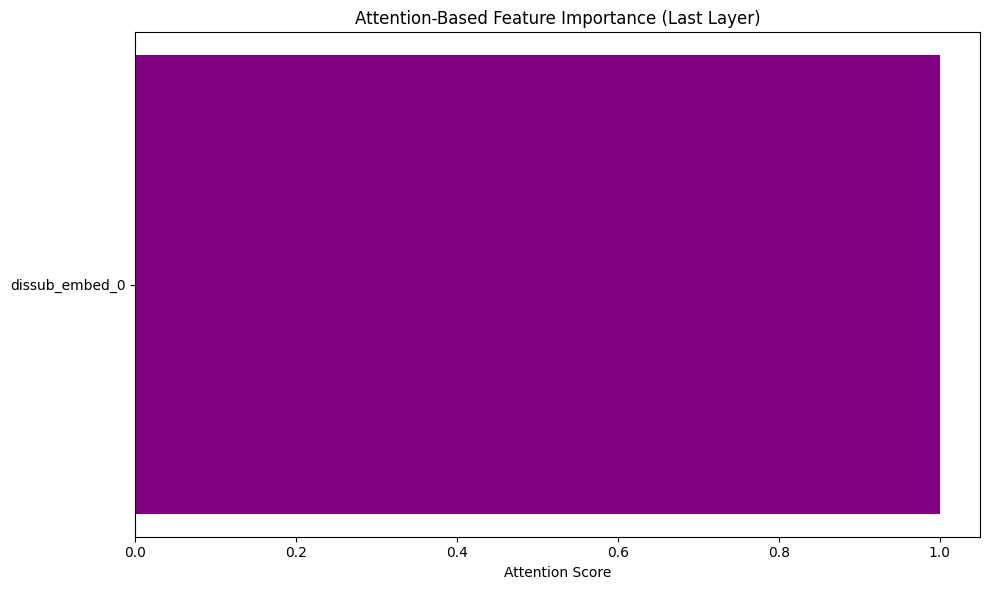

In [75]:
# Attention Importance (if applicable to the model architecture)
print("\nGenerating attention-based importance...")
attn_imp = AttentionImportance(sr_model) # Use the single-risk model

try:
    attention_scores = attn_imp.compute_importance(
        {'continuous': X_test[:20]},  # Use a small subset
        feature_names=processed_df.columns.tolist(),
        layer_idx=-1 # Use last layer's attention
    )

    # Plot attention importance
    fig15 = attn_imp.plot_importance(attention_scores)
    plt.title("Attention-Based Feature Importance (Last Layer)")
    plt.tight_layout()
    fig15.savefig("plots/attention_importance.png")
    plt.show()
    plt.close(fig15)
except Exception as e:
    print(f"Could not compute or plot attention importance: {e}")
    print("(This might happen if the model doesn't use standard attention layers or if indexing fails)")

## 10. Demonstration 4: Using Sample Weights

Demonstrate how to incorporate sample weights during training to prioritize certain samples (e.g., patients who experienced an event).

In [76]:
print("\n--- DEMONSTRATION 4: USING SAMPLE WEIGHTS ---\n")

# Create sample weights for our dataset
print("Creating sample weights...")
# We'll create weights that prioritize:
# 1. Patients who had an event (weight = 2.0)
# 2. Patients with certain characteristics (e.g., age > 40, weight = 1.5)
# 3. All other patients (weight = 1.0)

sample_weights = np.ones(len(ebmt_data))

# Assign higher weight to patients who had an event
event_mask_orig = ebmt_data['event_indicator'] == 1 # Use original event indicator
sample_weights[event_mask_orig] = 2.0

# Assign medium weight to older patients (if not already weighted higher)
age_mask = ebmt_data['age'] == ">40"
sample_weights[age_mask & ~event_mask_orig] = 1.5

print(f"Sample weights created: {len(sample_weights)} weight values")
unique_weights, counts = np.unique(sample_weights, return_counts=True)
print(f"Weight distribution: {dict(zip(unique_weights, counts))}")

# Convert to tensor
sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float32)


--- DEMONSTRATION 4: USING SAMPLE WEIGHTS ---

Creating sample weights...
Sample weights created: 8966 weight values
Weight distribution: {1.0: 4399, 1.5: 1257, 2.0: 3310}


In [77]:
# Create a weighted dataset class
class WeightedSurvivalDataset(torch.utils.data.Dataset):
    def __init__(self, X, weights, sr_targets=None, binary_targets=None, regression_targets=None):
        self.X = X
        self.weights = weights
        self.sr_targets = sr_targets
        self.binary_targets = binary_targets
        self.regression_targets = regression_targets
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        item = {'continuous': self.X[idx]}
        targets = {}
        
        if self.sr_targets is not None:
            targets['survival'] = self.sr_targets[idx]
            
        if self.binary_targets is not None:
            targets['binary'] = self.binary_targets[idx]
            
        if self.regression_targets is not None:
            targets['regression'] = self.regression_targets[idx]
            
        item['targets'] = targets
        # Add sample weight to the item dictionary
        item['sample_weights'] = self.weights[idx]
        return item

print("WeightedSurvivalDataset class defined.")

WeightedSurvivalDataset class defined.


In [78]:
# Create datasets with and without sample weights for comparison
print("\nCreating weighted and unweighted datasets for comparison...")
# 1. Dataset without weights (using SurvivalDataset)
unweighted_dataset_comp = SurvivalDataset(
    X_tensor,
    sr_targets=single_risk_tensor,
    binary_targets=binary_tensor
)

# 2. Dataset with weights (using WeightedSurvivalDataset)
weighted_dataset_comp = WeightedSurvivalDataset(
    X_tensor,
    weights=sample_weights_tensor,
    sr_targets=single_risk_tensor,
    binary_targets=binary_tensor
)

# Split data - use the same generator seed to ensure identical splits
train_size = int(0.7 * len(unweighted_dataset_comp))
val_size = int(0.15 * len(unweighted_dataset_comp))
test_size = len(unweighted_dataset_comp) - train_size - val_size

generator = torch.Generator().manual_seed(42)

unweighted_train, unweighted_val, unweighted_test = torch.utils.data.random_split(
    unweighted_dataset_comp, [train_size, val_size, test_size], generator=generator
)

# Need to reset generator for the second split to be identical
generator = torch.Generator().manual_seed(42)
weighted_train, weighted_val, weighted_test = torch.utils.data.random_split(
    weighted_dataset_comp, [train_size, val_size, test_size], generator=generator
)

# Create dataloaders
unweighted_train_loader = torch.utils.data.DataLoader(unweighted_train, batch_size=batch_size, shuffle=True)
unweighted_val_loader = torch.utils.data.DataLoader(unweighted_val, batch_size=batch_size)

weighted_train_loader = torch.utils.data.DataLoader(weighted_train, batch_size=batch_size, shuffle=True)
weighted_val_loader = torch.utils.data.DataLoader(weighted_val, batch_size=batch_size)

print("Datasets prepared for sample weight comparison.")


Creating weighted and unweighted datasets for comparison...
Datasets prepared for sample weight comparison.


In [79]:
# Create two identical model configurations (Survival + Binary tasks)
print("\nCreating task heads and models for comparison...")

def create_comp_model(num_features):
    survival_head = SingleRiskHead(
        name='survival',
        input_dim=64,
        num_time_bins=num_time_bins,
        alpha_rank=0.1,
        alpha_calibration=0.0
    )
    binary_head = ClassificationHead(
        name='binary',
        input_dim=64,
        num_classes=2,
        task_weight=1.0
    )
    model = EnhancedDeepHit(
        num_continuous=num_features,
        targets=[survival_head, binary_head],
        encoder_dim=64,
        encoder_depth=2,
        encoder_heads=4,
        include_variational=False,  # Disable variational for simplicity
        device='cpu'
    )
    return model

# Create unweighted model
torch.manual_seed(42) # Reset seed before creating model
unweighted_model = create_comp_model(X_tensor.shape[1])

# Create weighted model (identical architecture)
torch.manual_seed(42) # Reset seed again to ensure same initial weights
weighted_model = create_comp_model(X_tensor.shape[1])

print("Identical models created for weighted and unweighted training.")


Creating task heads and models for comparison...
Identical models created for weighted and unweighted training.


In [80]:
# Train the models
print("\nTraining model WITHOUT sample weights...")
unweighted_history = unweighted_model.fit(
    train_loader=unweighted_train_loader,
    val_loader=unweighted_val_loader,
    num_epochs=5,  # Reduced for demonstration
    learning_rate=0.001,
    patience=3,
    use_sample_weights=False  # Explicitly disable
)
print("Unweighted model training complete.")


Training model WITHOUT sample weights...
Epoch 1/5, Train Loss: 0.9624, Val Loss: 0.8876
  survival_c_index: 0.5902
  survival_brier_score: 0.2211
  survival_auc: 0.6051
  binary_accuracy: 0.7113
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.5273
Epoch 2/5, Train Loss: 0.8990, Val Loss: 0.8808
  survival_c_index: 0.5898
  survival_brier_score: 0.2585
  survival_auc: 0.6022
  binary_accuracy: 0.7113
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.4748
Epoch 3/5, Train Loss: 0.8970, Val Loss: 0.8801
  survival_c_index: 0.5920
  survival_brier_score: 0.2757
  survival_auc: 0.6042
  binary_accuracy: 0.7113
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.4678
Epoch 4/5, Train Loss: 0.8931, Val Loss: 0.8819
  survival_c_index: 0.5910
  survival_brier_score: 0.2908
  survival_auc: 0.6035
  binary_accuracy: 0.7113
  binary_f1_score: 0.0000
  binary_precision

In [81]:
print("\nTraining model WITH sample weights...")
weighted_history = weighted_model.fit(
    train_loader=weighted_train_loader,
    val_loader=weighted_val_loader,
    num_epochs=5,  # Reduced for demonstration
    learning_rate=0.001,
    patience=3,
    use_sample_weights=True  # Enable sample weights
)
print("Weighted model training complete.")


Training model WITH sample weights...
Epoch 1/5, Train Loss: 1.0157, Val Loss: 0.9666
  survival_c_index: 0.5735
  survival_brier_score: 0.2049
  survival_auc: 0.5822
  binary_accuracy: 0.7113
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.5221
Epoch 2/5, Train Loss: 0.9795, Val Loss: 0.9680
  survival_c_index: 0.5818
  survival_brier_score: 0.2110
  survival_auc: 0.5903
  binary_accuracy: 0.7113
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.4808
Epoch 3/5, Train Loss: 0.9723, Val Loss: 0.9708
  survival_c_index: 0.5820
  survival_brier_score: 0.2150
  survival_auc: 0.5914
  binary_accuracy: 0.7113
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.4787
Epoch 4/5, Train Loss: 0.9700, Val Loss: 0.9608
  survival_c_index: 0.5814
  survival_brier_score: 0.2174
  survival_auc: 0.5909
  binary_accuracy: 0.7113
  binary_f1_score: 0.0000
  binary_precision: 0

### Evaluate and Compare Weighted vs. Unweighted Models

In [84]:
# Evaluate and compare models
print("\nEvaluating and comparing models...")

# Extract test data features and targets
X_test_comp = torch.cat([unweighted_test[i]['continuous'].unsqueeze(0) for i in range(len(unweighted_test))])
y_test_survival_comp = torch.cat([unweighted_test[i]['targets']['survival'].unsqueeze(0) for i in range(len(unweighted_test))])
y_test_binary_comp = torch.cat([unweighted_test[i]['targets']['binary'].unsqueeze(0) for i in range(len(unweighted_test))])

# Generate predictions for both models on the same test set
unweighted_preds = unweighted_model.predict(X_test_comp)
weighted_preds = weighted_model.predict(X_test_comp)

# Extract predictions for comparison
unwght_survival = unweighted_preds['task_outputs']['survival']['survival'].detach().numpy()
unwght_binary = unweighted_preds['task_outputs']['binary']['probabilities'].detach().numpy() # Prob class 1

wght_survival = weighted_preds['task_outputs']['survival']['survival'].detach().numpy()
wght_binary = weighted_preds['task_outputs']['binary']['probabilities'].detach().numpy() # Prob class 1

print("\nPrediction comparison (mean values on test set):")
print(f"Unweighted survival mean: {np.mean(unwght_survival):.4f}")
print(f"Weighted survival mean:   {np.mean(wght_survival):.4f}")
print(f"Unweighted binary mean:   {np.mean(unwght_binary):.4f}")
print(f"Weighted binary mean:     {np.mean(wght_binary):.4f}")


Evaluating and comparing models...

Prediction comparison (mean values on test set):
Unweighted survival mean: 0.6229
Weighted survival mean:   0.4822
Unweighted binary mean:   0.3236
Weighted binary mean:     0.2794



Plotting comparison visualizations...


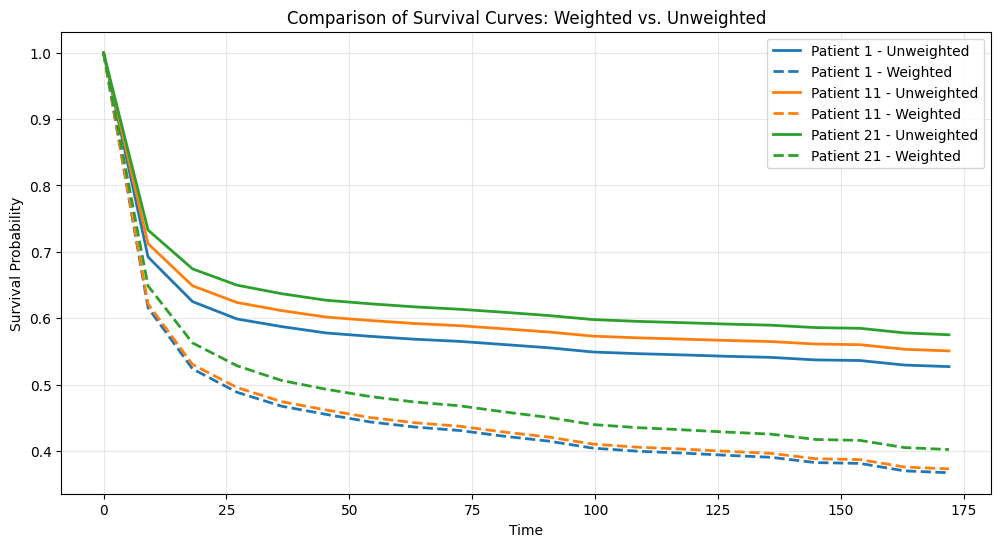

In [85]:
# Plot comparisons
print("\nPlotting comparison visualizations...")

# 1. Plot survival curves for both models for sample patients
fig_sw1, ax_sw1 = plt.subplots(figsize=(12, 6))

# Select sample patients to plot (indices from the test set)
sample_indices = [0, 10, 20] 

for i, idx in enumerate(sample_indices):
    if idx < len(unwght_survival):
        # Plot unweighted model prediction
        ax_sw1.plot(time_points, unwght_survival[idx], 
                 label=f'Patient {idx+1} - Unweighted', 
                 linestyle='-', linewidth=2, 
                 color=f'C{i}')
        
        # Plot weighted model prediction
        ax_sw1.plot(time_points, wght_survival[idx], 
                 label=f'Patient {idx+1} - Weighted', 
                 linestyle='--', linewidth=2, 
                 color=f'C{i}')

ax_sw1.set_xlabel('Time')
ax_sw1.set_ylabel('Survival Probability')
ax_sw1.set_title('Comparison of Survival Curves: Weighted vs. Unweighted')
ax_sw1.legend()
ax_sw1.grid(True, alpha=0.3)
fig_sw1.savefig("plots/weighted_vs_unweighted_survival.png")
plt.show()
plt.close(fig_sw1)

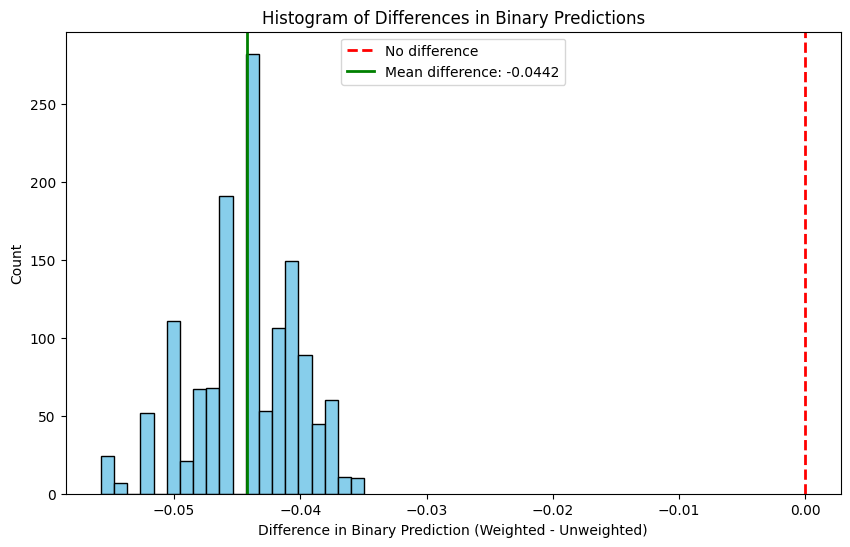

In [86]:
# 2. Compare binary classification predictions (histogram of differences)
fig_sw2, ax_sw2 = plt.subplots(figsize=(10, 6))

# Calculate the difference between weighted and unweighted binary predictions
binary_diff = wght_binary.flatten() - unwght_binary.flatten()

# Create histogram of differences
ax_sw2.hist(binary_diff, bins=20, color='skyblue', edgecolor='black')
ax_sw2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference')
mean_diff = np.mean(binary_diff)
ax_sw2.axvline(x=mean_diff, color='green', linestyle='-', linewidth=2, 
           label=f'Mean difference: {mean_diff:.4f}')

ax_sw2.set_xlabel('Difference in Binary Prediction (Weighted - Unweighted)')
ax_sw2.set_ylabel('Count')
ax_sw2.set_title('Histogram of Differences in Binary Predictions')
ax_sw2.legend()
fig_sw2.savefig("plots/weighted_vs_unweighted_binary.png")
plt.show()
plt.close(fig_sw2)

In [87]:
# 3. Performance analysis: Compare accuracy on different groups

# Extract event indicators from the test survival targets
event_mask_test = y_test_survival_comp[:, 0] == 1
event_indices_test = event_mask_test.nonzero().squeeze().numpy()
non_event_indices_test = (~event_mask_test).nonzero().squeeze().numpy()

# Get actual binary targets for the test set
binary_targets_test = y_test_binary_comp.numpy().flatten()

# Calculate correctness for binary task
binary_correct_unweighted = ((unwght_binary.flatten() > 0.5) == binary_targets_test).astype(int)
binary_correct_weighted = ((wght_binary.flatten() > 0.5) == binary_targets_test).astype(int)

# Calculate accuracy for events vs non-events
print("\nBinary classification accuracy by event status:")
acc_unweighted_overall = np.mean(binary_correct_unweighted)
acc_weighted_overall = np.mean(binary_correct_weighted)
print(f"Unweighted model accuracy (overall): {acc_unweighted_overall:.4f}")
print(f"Weighted model accuracy (overall):   {acc_weighted_overall:.4f}")

print("\nEffect of sample weighting on different groups:")
if len(event_indices_test) > 0:
    acc_unweighted_event = np.mean(binary_correct_unweighted[event_indices_test])
    acc_weighted_event = np.mean(binary_correct_weighted[event_indices_test])
    print("1. Performance on patients with an event (weighted higher):")
    print(f"   - Unweighted model accuracy: {acc_unweighted_event:.4f}")
    print(f"   - Weighted model accuracy:   {acc_weighted_event:.4f}")
    print(f"   - Improvement:             {acc_weighted_event - acc_unweighted_event:.4f}")
else:
    print("1. No patients with events in the test set.")

if len(non_event_indices_test) > 0:
    acc_unweighted_nonevent = np.mean(binary_correct_unweighted[non_event_indices_test])
    acc_weighted_nonevent = np.mean(binary_correct_weighted[non_event_indices_test])
    print("\n2. Performance on patients without an event (weighted lower):")
    print(f"   - Unweighted model accuracy: {acc_unweighted_nonevent:.4f}")
    print(f"   - Weighted model accuracy:   {acc_weighted_nonevent:.4f}")
    print(f"   - Improvement:             {acc_weighted_nonevent - acc_unweighted_nonevent:.4f}")
else:
    print("2. No patients without events in the test set.")


Binary classification accuracy by event status:
Unweighted model accuracy (overall): 0.7147
Weighted model accuracy (overall):   0.7147

Effect of sample weighting on different groups:
1. Performance on patients with an event (weighted higher):
   - Unweighted model accuracy: 0.7143
   - Weighted model accuracy:   0.7143
   - Improvement:             0.0000

2. Performance on patients without an event (weighted lower):
   - Unweighted model accuracy: 0.7149
   - Weighted model accuracy:   0.7149
   - Improvement:             0.0000


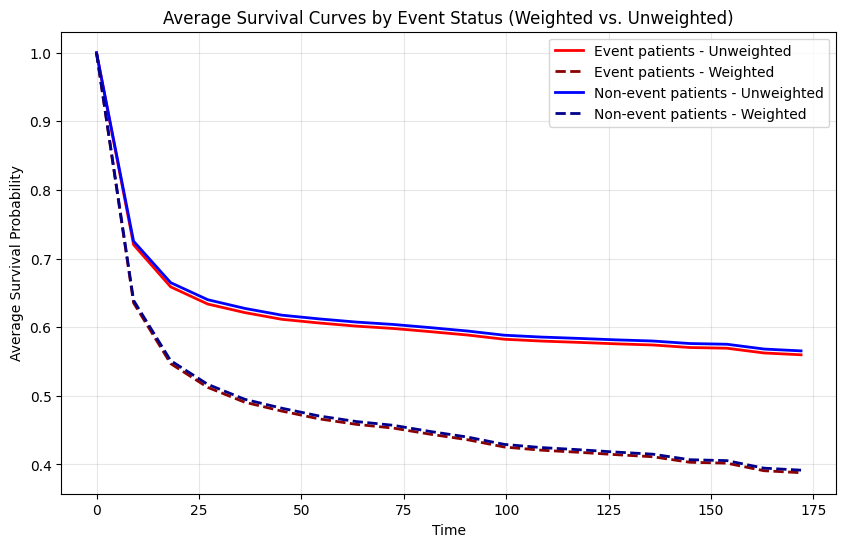

In [88]:
# 4. Compare average survival curves by event status
fig_sw3, ax_sw3 = plt.subplots(figsize=(10, 6))

# Calculate average survival curves for each model and patient group
if len(event_indices_test) > 0:
    survival_event_unwght = np.mean(unwght_survival[event_indices_test], axis=0)
    survival_event_wght = np.mean(wght_survival[event_indices_test], axis=0)
    ax_sw3.plot(time_points, survival_event_unwght, label='Event patients - Unweighted', 
             linestyle='-', linewidth=2, color='red')
    ax_sw3.plot(time_points, survival_event_wght, label='Event patients - Weighted', 
             linestyle='--', linewidth=2, color='darkred')

if len(non_event_indices_test) > 0:
    survival_nonevent_unwght = np.mean(unwght_survival[non_event_indices_test], axis=0)
    survival_nonevent_wght = np.mean(wght_survival[non_event_indices_test], axis=0)
    ax_sw3.plot(time_points, survival_nonevent_unwght, label='Non-event patients - Unweighted', 
             linestyle='-', linewidth=2, color='blue')
    ax_sw3.plot(time_points, survival_nonevent_wght, label='Non-event patients - Weighted', 
             linestyle='--', linewidth=2, color='darkblue')

ax_sw3.set_xlabel('Time')
ax_sw3.set_ylabel('Average Survival Probability')
ax_sw3.set_title('Average Survival Curves by Event Status (Weighted vs. Unweighted)')
ax_sw3.legend()
ax_sw3.grid(True, alpha=0.3)
fig_sw3.savefig("plots/weighted_survival_by_event.png")
plt.show()
plt.close(fig_sw3)

In [89]:
print("\nVignette execution completed successfully!")
print(f"All plots have been saved to: {os.path.abspath('plots')}")


Vignette execution completed successfully!
All plots have been saved to: /Users/denizakdemir/Dropbox/dakdemirGithub/GitHubProjects/TSUNAMI/vignettes/plots
